# Importing Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
from datetime import datetime
import datasets
from datasets import load_dataset
import logging
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Input, Concatenate, Attention
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable

# Configure logging
logging.basicConfig(
    filename=f'sentiment_analysis_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

2024-12-02 01:29:16.412755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ys/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading dataset
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

In [4]:
dataset["full"][0]

{'rating': 5.0,
 'title': 'Such a lovely scent but not overpowering.',
 'text': "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!",
 'images': [],
 'asin': 'B00YQ6X8EO',
 'parent_asin': 'B00YQ6X8EO',
 'user_id': 'AGKHLEW2SOWHNMFQIJGBECAF7INQ',
 'timestamp': 1588687728923,
 'helpful_vote': 0,
 'verified_purchase': True}

In [5]:
# Converts dataset to a DataFrame
df_amz = dataset["full"].to_pandas()

In [6]:
df_amz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701528 entries, 0 to 701527
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             701528 non-null  float64
 1   title              701528 non-null  object 
 2   text               701528 non-null  object 
 3   images             701528 non-null  object 
 4   asin               701528 non-null  object 
 5   parent_asin        701528 non-null  object 
 6   user_id            701528 non-null  object 
 7   timestamp          701528 non-null  int64  
 8   helpful_vote       701528 non-null  int64  
 9   verified_purchase  701528 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 48.8+ MB


In [7]:
df_amz.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [8]:
rating_counts = df_amz['rating'].value_counts().sort_index()
rating_counts_df = rating_counts.reset_index()
rating_counts_df.columns = ['Rating', 'Count']
print(rating_counts_df)

   Rating   Count
0     1.0  102080
1     2.0   43034
2     3.0   56307
3     4.0   79381
4     5.0  420726


# Pre-prossesing Functions

In [ ]:
#pre-processing and using 10000 random samples
def preprocess_amazon_data(df, max_samples=10000):
    logging.info("Starting data preprocessing")
    
    try:
        # Data Cleaning
        df_filtered = df[['text', 'title', 'rating', 'timestamp', 'helpful_vote']].copy()
        
        # Combine title and text
        df_filtered['combined_text'] = df_filtered.apply(
            lambda x: f"{x['title']} {x['text']}", axis=1
        )
        
        # Text normalization : removing urls, punctuations, whitespaces
        def normalize_text(text):
            text = text.lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
        
        df_filtered['normalized_text'] = df_filtered['combined_text'].apply(normalize_text)
        
        # Sentiment Classification
        df_filtered['sentiment'] = df_filtered['rating'].apply(
            lambda x: 1 if x >= 4 else (0 if x <= 2 else 2)
        )
        
        # Remove neutral reviews
        df_filtered = df_filtered[df_filtered['sentiment'] != 2]
        
        # Balance Dataset
        min_samples = min(min(df_filtered['sentiment'].value_counts()), max_samples // 2)
        df_balanced = pd.concat([
            df_filtered[df_filtered['sentiment'] == label].sample(min_samples)
            for label in [0, 1]
        ])
        
        logging.info(f"Preprocessing completed. Final dataset shape: {df_balanced.shape}")
        return df_balanced
        
    except Exception as e:
        logging.error(f"Error in preprocessing: {str(e)}")
        raise

# Model Function

In [70]:
@keras.saving.register_keras_serializable()
class DistilBertWrapper(tf.keras.layers.Layer):
    def __init__(self, max_length=128, **kwargs):
        super().__init__(**kwargs)
        self.bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
        self.max_length = max_length
        logging.info("DistilBertWrapper initialized with max_length=%d", max_length)
        
    def call(self, inputs):
        logging.info("Calling DistilBertWrapper with inputs: %s", inputs)
        return self.bert(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask']
        )[0]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "max_length": self.max_length
        })
        return config    

class SentimentAnalysisModel:
    def __init__(self, max_length=128, num_classes=2):
        self.max_length = max_length
        self.num_classes = num_classes
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        logging.info("SentimentAnalysisModel initialized with max_length=%d and num_classes=%d", max_length, num_classes)
        
    def create_hybrid_model(self):
        try:
            logging.info("Creating hybrid model...")
            # Define inputs
            input_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids')
            attention_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask')
            
            # Use the wrapper layer
            bert_layer = DistilBertWrapper(self.max_length)
            sequence_output = bert_layer({'input_ids': input_ids, 'attention_mask': attention_mask})
            
            # Add BiGRU and attention layers
            gru_layer = Bidirectional(GRU(128, return_sequences=True))(sequence_output)
            attention_layer = tf.keras.layers.Attention()([gru_layer, gru_layer])
            
            # Dense layers
            x = tf.keras.layers.GlobalAveragePooling1D()(attention_layer)
            x = Dense(256, activation='relu')(x)
            x = tf.keras.layers.Dropout(0.3)(x)
            outputs = Dense(self.num_classes, activation='softmax')(x)
            
            model = tf.keras.Model(
                inputs={'input_ids': input_ids, 'attention_mask': attention_mask},
                outputs=outputs
            )
            logging.info("Hybrid model created successfully.")
            return model
            
        except Exception as e:
            logging.error(f"Error creating model: {str(e)}")
            raise

In [16]:
class ModelTrainer:
    def __init__(self, model, tokenizer, max_length=128):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        logging.info("ModelTrainer initialized with max_length=%d", max_length)
    
    def prepare_data(self, texts, labels):
        logging.info("Preparing data with %d texts", len(texts))
        # Tokenize the texts
        encodings = self.tokenizer(
            list(texts),
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='tf'
        )
        
        # Convert to TensorFlow tensors
        dataset = {
            'input_ids': tf.cast(encodings['input_ids'], tf.int32),
            'attention_mask': tf.cast(encodings['attention_mask'], tf.int32)
        }
        logging.info("Data preparation complete")
        return dataset, tf.cast(labels, tf.int32)
    
    def train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=32):
        logging.info("Starting training for %d epochs with batch size %d", epochs, batch_size)
        # Prepare datasets
        train_data, train_labels = self.prepare_data(X_train, y_train)
        val_data, val_labels = self.prepare_data(X_val, y_val)
        
        # Create TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((
            train_data,
            train_labels
        )).shuffle(1000).batch(batch_size)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((
            val_data,
            val_labels
        )).batch(batch_size)
        
        # Train the model
        history = self.model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=2,
                    restore_best_weights=True
                )
            ]
        )
        logging.info("Training complete")
        return history

# Model Training

In [17]:
# Load data
df_balanced = preprocess_amazon_data(df_amz)

In [19]:
df_balanced.head()

,text,title,rating,timestamp,helpful_vote,combined_text,normalized_text,sentiment
189180,I can only assume this oil is old as there is ...,Waste of 12 dollars!,1.0,1477572916000,0,Waste of 12 dollars! I can only assume this oi...,waste of 12 dollars i can only assume this oil...,0
121613,Do not recommend. Although super fun idea! Mad...,Dries the hair too much,1.0,1666155181783,0,Dries the hair too much Do not recommend. Alth...,dries the hair too much do not recommend altho...,0
20098,The fact that this product is from China was o...,Product from China: Picture on site different ...,1.0,1596031411728,2,Product from China: Picture on site different ...,product from china picture on site different f...,0
397770,I used this for 3 nights and on the 4th night ...,Empty tube can’t fill lashes,1.0,1523069906653,0,Empty tube can’t fill lashes I used this for 3...,empty tube cant fill lashes i used this for 3 ...,0
67774,"Very pretty, but half of them arrived smashed ...",Pretty but arrived smashed,2.0,1523311357471,0,"Pretty but arrived smashed Very pretty, but ha...",pretty but arrived smashed very pretty but hal...,0


In [38]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 189180 to 252150
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             10000 non-null  object 
 1   title            10000 non-null  object 
 2   rating           10000 non-null  float64
 3   timestamp        10000 non-null  int64  
 4   helpful_vote     10000 non-null  int64  
 5   combined_text    10000 non-null  object 
 6   normalized_text  10000 non-null  object 
 7   sentiment        10000 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 703.1+ KB


In [20]:
X = df_balanced['normalized_text'].values
y = df_balanced['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train

array(['five stars works well',
       'awful this hair sheds and is so thin it is the worst hair and it tangles awfully bad',
       'unluck of the draw 3 pinks and 3 off white seller needs to be considerate and give a better variety of colorsbr i guess its my fault for ordering a random lot in the middle of winter i hate pastels',
       ...,
       'the only lipstick i use excellent product beautiful color it is the only product i use',
       'weak bristles does not work well bristles are weak in terms of effectiveness no better than running your hand across your face',
       'cute super cute'], dtype=object)

In [23]:
y_train

array([1, 0, 0, ..., 1, 0, 1])

In [24]:
# Initializing and compililing model
sentiment_model = SentimentAnalysisModel()
model = sentiment_model.create_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [25]:
# Train model
trainer = ModelTrainer(model, sentiment_model.tokenizer)
history = trainer.train(X_train, y_train, X_test, y_test)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.6114 - loss: 0.6611 - val_accuracy: 0.8330 - val_loss: 0.5485
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 904s 4s/step - accuracy: 0.7982 - loss: 0.5278 - val_accuracy: 0.8695 - val_loss: 0.4329
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 864s 3s/step - accuracy: 0.8417 - loss: 0.4217 - val_accuracy: 0.8845 - val_loss: 0.3452


In [50]:
model.save('sentiment_model.keras', save_format='keras')
sentiment_model.tokenizer.save_pretrained('sentiment_tokenizer')

('sentiment_tokenizer/tokenizer_config.json',
 'sentiment_tokenizer/special_tokens_map.json',
 'sentiment_tokenizer/vocab.txt',
 'sentiment_tokenizer/added_tokens.json')

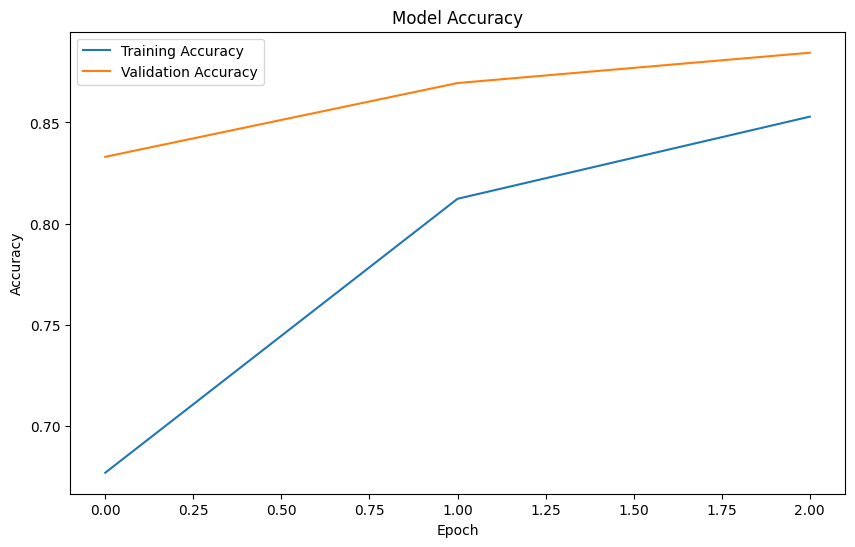

In [29]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model Prediction

In [30]:
def predict_sentiment(text, model, tokenizer, max_length=128):
    # Preprocess the input text
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    encodings = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )
    
    # Make prediction
    outputs = model.predict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    })
    
    # Get prediction label
    prediction = tf.argmax(outputs, axis=1)[0]
    sentiment = "Positive" if prediction == 1 else "Negative"
    confidence = float(outputs[0][prediction])
    
    return sentiment, confidence

In [34]:
# Example usage
sample_text = "This product is good if you want to waste your money"
sentiment, confidence = predict_sentiment(sample_text, model, sentiment_model.tokenizer)
print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Sentiment: Negative
Confidence: 0.69


In [33]:
# Example usage
sample_text = "This product is good for the skin"
sentiment, confidence = predict_sentiment(sample_text, model, sentiment_model.tokenizer)
print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Sentiment: Positive
Confidence: 0.86


In [35]:
# Example usage
sample_text = "The product does not work"
sentiment, confidence = predict_sentiment(sample_text, model, sentiment_model.tokenizer)
print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Sentiment: Negative
Confidence: 0.88


In [37]:
# Prepare test data
test_encodings = sentiment_model.tokenizer(
    X_test.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='tf'
)

# Make predictions
predictions = model.predict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

# Convert predictions to labels
predicted_labels = tf.argmax(predictions, axis=1)

# Generate classification report
print(classification_report(y_test, predicted_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1012
           1       0.90      0.86      0.88       988

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000



In [52]:
# Load the model with custom objects
custom_objects = {'DistilBertWrapper': DistilBertWrapper}
loaded_model = tf.keras.models.load_model('sentiment_model.keras', custom_objects=custom_objects)

# Load the tokenizer
loaded_tokenizer = DistilBertTokenizer.from_pretrained('sentiment_tokenizer')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [53]:
# Example usage
text = "This product is amazing!"
sentiment, confidence = predict_sentiment(text, loaded_model, loaded_tokenizer)
print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Sentiment: Positive
Confidence: 0.97


In [ ]:
print("Model Summary:")
model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_wrapper │ (None, 128, 768)  │          0 │ attention_mask[0… │
│ (DistilBertWrapper) │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    689,664 │ distil_bert_wrap… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128, 256)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        514 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,267,912 (8.65 MB)

 Trainable params: 755,970 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,511,942 (5.77 MB)

In [69]:
import netron
# Start Netron visualization
netron.start('sentiment_model.keras')

Serving 'sentiment_model.keras' at http://localhost:8080


('localhost', 8080)